# Explore here

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Importación de datos

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv', sep=",")

# Análisis exploratorio 

In [4]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


- Todas son variables numéricas, eso ayuda porque no tendré que convertir variables categóricas en numéricas

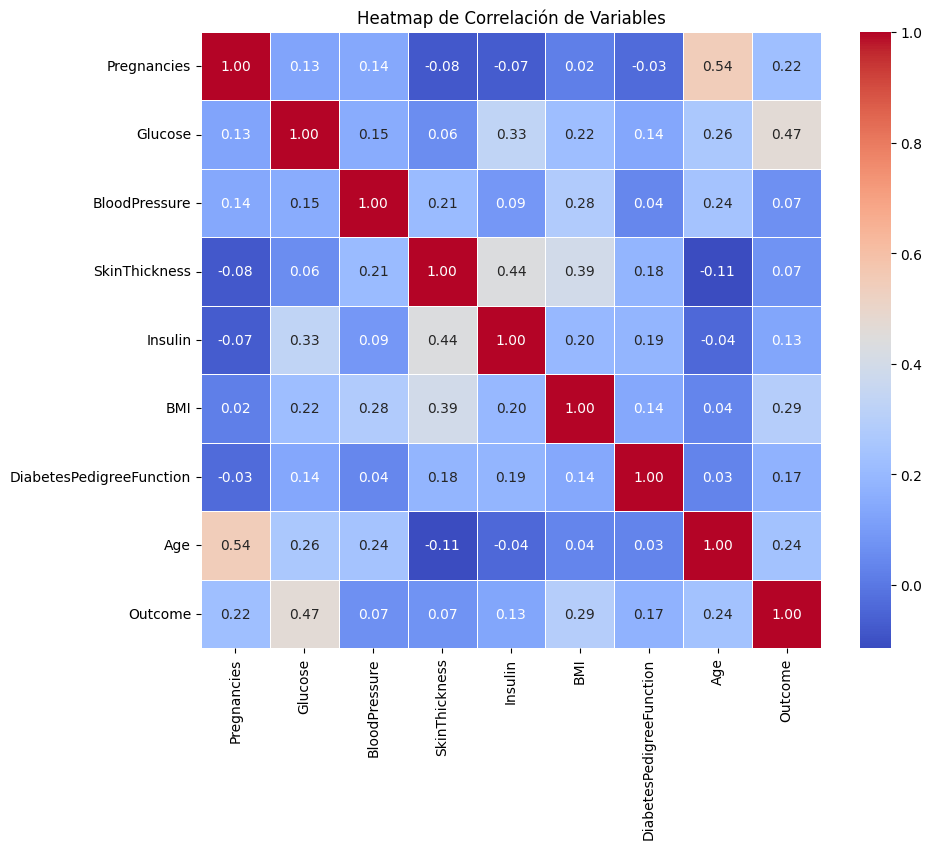

In [6]:
matriz_correlacion = df.corr()
plt.figure(figsize=(10, 8)) # Ajusta el tamaño para una mejor visualización
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Heatmap de Correlación de Variables')
plt.show()

- Las variables que están correlacionadas medianamente son:
  - La edad con los embarazos que tuvieron las personas
  - La glucosa con el outcome que considero que es la más importante
  - Y el espesor de la piel con el indice de masa corporal

In [7]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


- A simple vista puedo decir que todas las variables se van a necesitar, por lo que tampoco tendré que eliminar ninguna.
- La desviación estandar de la insulina es alta
- Por la naturaleza de los arboles de decisión no se tienen que normalizar los datos por lo que se quedarán así
- Que las variables aparte de los embarazos que tuvieron las personas estén en 0 causa un poco de ruido, entonces vamos a ver si existen valores nulos

In [8]:
ceros_por_columna = (df == 0).sum()
ceros_por_columna

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

- Investigando, al parecer cuando existen esta cantidad de "0", una buena manera de manejarlos es imputar la mediana, ya que:
  - Así no tenemos que eliminarlos y así no perder significante cantidad de información
  - Si imputamos con la media, tendríamos un resultado artificial que no serviría porque estaríamos manipulando la información para que se incline más a la media

In [9]:
columnas_con_cero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for col in columnas_con_cero:
    mediana = df[col].median()
    df[col] = df[col].replace(0, mediana)

In [10]:
ceros_por_columna = (df == 0).sum()
ceros_por_columna

Pregnancies                 111
Glucose                       0
BloodPressure                 0
SkinThickness                 0
Insulin                       0
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

### Conteo de valores en la variable objetivo para ver si está desbalanceada

In [11]:
df['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [12]:
df['Outcome'].value_counts(normalize=True) * 100

Outcome
0    65.104167
1    34.895833
Name: proportion, dtype: float64

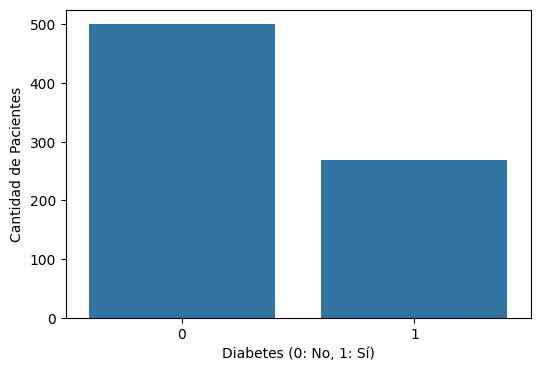

In [13]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Outcome', data=df)
plt.xlabel('Diabetes (0: No, 1: Sí)')
plt.ylabel('Cantidad de Pacientes')
plt.show()

- Aquí veo que es mas o menos el doble de los valores que tiene la clase de "0", entonces se puede decir que sí está un poco desbalanceada, pero voy a entrenarlo para ver los resultados

# Entrenamiento del modelo

In [14]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

- Aquí vamos a definir el modelo con un criterio gini

In [16]:
modelo = DecisionTreeClassifier(criterion='gini', random_state=42, class_weight='balanced')

modelo.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

- Aquí mostramos la predicción

In [18]:
y_pred = modelo.predict(X_test)
y_pred

array([1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0])

- Y obtenemos un 67% aproximadamente. Lo cual no es el mejor resultado, podemos esperar algo mejor

In [20]:
accuracy_score(y_test, y_pred)

0.6753246753246753

In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.79      0.76       100
           1       0.54      0.46      0.50        54

    accuracy                           0.68       154
   macro avg       0.64      0.63      0.63       154
weighted avg       0.67      0.68      0.67       154



- Con estos resultados vamos a optimizar el modelo para ver si mejora el rendimiento

In [24]:
grid_parametros = {
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [1, 2, 3]
}

grid_search = GridSearchCV(estimator=modelo, param_grid=grid_parametros, cv=3, scoring='f1', n_jobs=-1)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7], 'min_samples_leaf': [1, 2, 3]},
             scoring='f1')

In [26]:
mejor_modelo = grid_search.best_estimator_
mejor_modelo

DecisionTreeClassifier(class_weight='balanced', max_depth=3, min_samples_leaf=2,
                       random_state=42)

- El mejor modelo encontrado fue con una profundidad de 3 y con 2 hojas

In [27]:
y_pred_optimizado = mejor_modelo.predict(X_test)
y_pred_optimizado

array([1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0])

In [28]:
accuracy_score(y_test, y_pred_optimizado)

0.6818181818181818

In [29]:
print(classification_report(y_test, y_pred_optimizado))

              precision    recall  f1-score   support

           0       0.88      0.59      0.71       100
           1       0.53      0.85      0.65        54

    accuracy                           0.68       154
   macro avg       0.70      0.72      0.68       154
weighted avg       0.76      0.68      0.69       154



- Vemos que sí mejoró bastante, casi 10% más en precisión, recall y f1-score, por lo que funcionó encontrar los mejores hiperparámetros para el modelo

### Guardado de modelo

In [32]:
file = open('decision_tree_model_optimized.pkl', 'wb')
pickle.dump(mejor_modelo, file)
file.close()

- Y también vamos a guardar el conjunto de datos limpio para utilizarlo en futuros proyectos

In [33]:
df.to_csv('diabetes_limpio.csv', index=False)